In [91]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import json
import cv2
import requests
import io
import math

from pprint import PrettyPrinter

import sys
sys.path.append('../')

import torch

import itertools
from panopticapi.utils import id2rgb, rgb2id
from PIL import Image

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

%load_ext autoreload
%autoreload 2
eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
coco_path = '/home/rezaeifa/Python/pytorch/data/coco/'  #path to coco directry
output_dir = '/home/rezaeifa/external/detr/output/panoptic_eval/' #path to output file of detr directry

In [94]:
with open(output_dir + 'predictions.json') as json_file:
    predictions = json.load(json_file)
    
with open(coco_path + 'annotations/' + 'panoptic_val2017.json') as json_file:
    annotations = json.load(json_file)

file_name = predictions['annotations'][0]['file_name'].rsplit(".", 1)[0]

pp = PrettyPrinter(indent=4)
pp.pprint(predictions['annotations'][0]['segments_info'])

[   {'area': 22061, 'category_id': 181, 'id': 0, 'isthing': False},
    {'area': 607, 'category_id': 62, 'id': 1, 'isthing': True},
    {'area': 2260, 'category_id': 44, 'id': 2, 'isthing': True},
    {'area': 677, 'category_id': 64, 'id': 3, 'isthing': True},
    {'area': 78, 'category_id': 86, 'id': 4, 'isthing': True},
    {'area': 2549, 'category_id': 1, 'id': 5, 'isthing': True},
    {'area': 22914, 'category_id': 186, 'id': 6, 'isthing': False},
    {'area': 100103, 'category_id': 199, 'id': 7, 'isthing': False},
    {'area': 4061, 'category_id': 188, 'id': 8, 'isthing': False},
    {'area': 1145, 'category_id': 62, 'id': 9, 'isthing': True},
    {'area': 75977, 'category_id': 118, 'id': 10, 'isthing': False},
    {'area': 151, 'category_id': 86, 'id': 11, 'isthing': True},
    {'area': 188, 'category_id': 85, 'id': 12, 'isthing': True},
    {'area': 3309, 'category_id': 62, 'id': 13, 'isthing': True},
    {'area': 949, 'category_id': 133, 'id': 14, 'isthing': False},
    {'area'

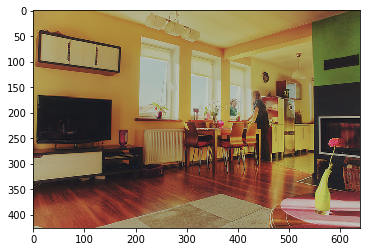

In [86]:
img = cv2.imread(coco_path + 'val2017/' + file_name + '.jpg')
plt.imshow(img[:,:, ::-1])

In [87]:
mask_output = cv2.imread(output_dir + file_name + '.png')
mask_gt = cv2.imread(coco_path+ 'panoptic_val2017/' + file_name + '.png')


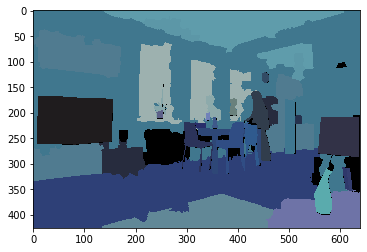

In [88]:
plt.imshow(mask_gt, cmap="gray")


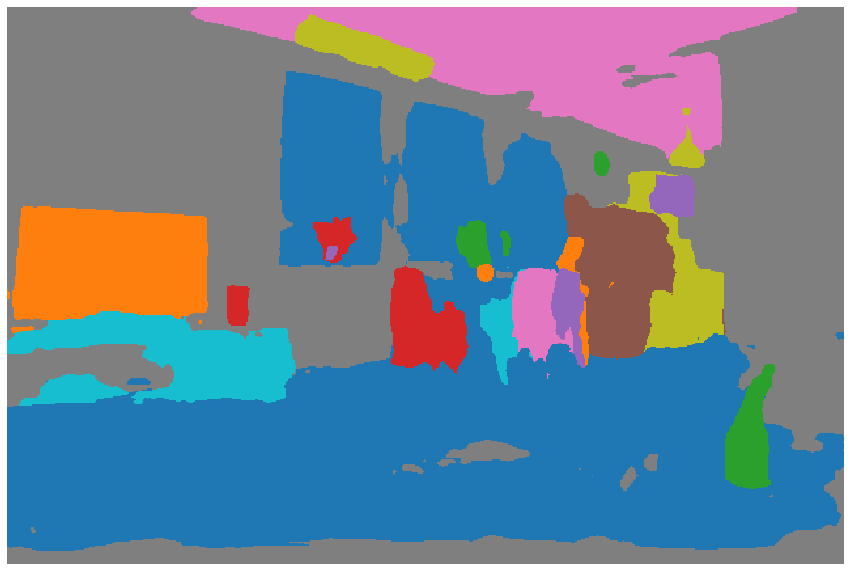

In [90]:
mask_output = cv2.imread(output_dir + file_name + '.png')[:,:, ::-1]
mask_id = rgb2id(mask_output)
palette = itertools.cycle(sns.color_palette())

mask_output[:, :, :] = 0
for id in range(mask_id.max() + 1):
    mask_output[mask_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(mask_output)
plt.axis('off')
plt.show()

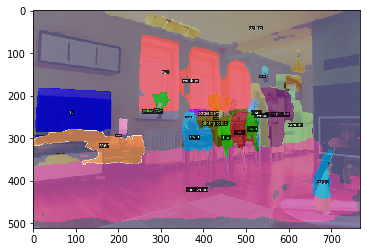

In [93]:
panoptic_seg = torch.from_numpy(mask_id)
segments_info = predictions['annotations'][0]['segments_info']
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]


v = Visualizer(img[:, :, ::-1], meta, scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info)
plt.imshow(v.get_image())